# COMP41680 Assignment 2:Text Scraping and Classification

## Import Packages

In [3]:
import bs4
import urllib
import pandas as pd
import os
import errno
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

## Part 1. Data Collection

In [66]:
#base url
base_url = "http://mlg.ucd.ie/modules/COMP41680/archive/"
#index_page 
index_page = "index.html"

extract the links from the given page

In [67]:
#get internal links
def get_internal_links(relative_url):
    href_links = []
    response = urllib.request.urlopen(base_url+relative_url)
    data = response.read().decode()
    parser = bs4.BeautifulSoup(data,"html.parser")
    for link in parser.find_all('a'):
        link_href = link.get('href')
        if link_href.startswith('month'):
            href_links.append(link_href)
    return href_links

In [68]:
# global Id is taken for the file names
TEXT_ID = 1

#### Methods of web scrapping

In [69]:
def get_category_article(relative_url):
    global TEXT_ID
    response = urllib.request.urlopen(base_url+relative_url)
    data = response.read().decode()
    parser = bs4.BeautifulSoup(data,"html.parser")
    table = parser.find("table").find('tbody')
    records = []
   
    for row in table.findAll('tr'):
        col = row.findAll('td')
        category = col[0]
        article = col[1]
        if category is not None and article is not None:
            news_link = article.find('a')
            if news_link is not None:
                data =[category.text.strip(), article.text.strip(), 'text'+str(TEXT_ID)] 
                records.append(data)
                news_content = get_news_content(news_link.get('href'))
                write_to_file(' '.join(news_content),'text'+str(TEXT_ID)+'.txt')
                TEXT_ID += 1
    return records

In [95]:
def get_news_content(relative_url):
    response = urllib.request.urlopen(base_url+relative_url)
    data = response.read().decode()
    parser = bs4.BeautifulSoup(data,"html.parser")
    text_body = []
    # find all p where class not equal to 'notice' (All article body has a notice which says "Return to article search page")
    for link1 in parser.findAll(['p','b'],class_=lambda x: x != 'notice'):
        text_body.append(''.join(link1.get_text()))
    return text_body

In [96]:
def write_to_file(article,filename):
    filename = 'articles/'+filename
    if not os.path.exists(os.path.dirname(filename)):
        try:
            os.makedirs(os.path.dirname(filename))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
    with open(filename, 'w', encoding="utf-8") as out:
        out.write(article)

### Call the above mentioned method to get the data from the web page

In [98]:
data = []
df = pd.DataFrame()
update_TextId()
for month_link in get_internal_links(index_page):
    data.extend(get_category_article(month_link))
df = pd.DataFrame(data,columns=['category','article_title', 'file_name'])
#store category and file mapping to a csv file
df.to_csv('category_file_mapping.csv', sep=',', encoding='utf-8')

## Part 2. Text Classification 

In [4]:
#reading the file
categoy_filename_mappring = pd.read_csv('category_file_mapping.csv')

In [5]:
#labels for the articles
labels = categoy_filename_mappring['category'].values

In [6]:
filenames = categoy_filename_mappring['file_name']
raw_documents = []
# read the articles
for f in filenames:
    fin = open('articles/'+f+".txt","r", encoding = "utf8")
    raw_text = fin.read().replace('\n', ' ')
    raw_documents.append(raw_text)
    fin.close()

## Text pre-processing

##### Steps used for Text preprocessing are as follows:

<ul>
    <li> Tokenisation</li>
    <li> Case Conversion (Sckit</li>
    <li> Filter Short Terms</li>
    <li> Filter StopWords</li>
    <li> Lemmatisation</li>
    <li> Filter Infrequent Terms</li>
    <li> Vectorization</li>
    <li> TF-IDF Weighting</li>
    <b>NB: By default Scikit-learn converts tokens to lowercase and removes
tokens of length 1 </b>
</ul>

In [7]:
# define the function
def lemma_tokenizer(text):
    # use the standard scikit-learn tokenizer first
    standard_tokenizer = CountVectorizer().build_tokenizer()
    tokens = standard_tokenizer(text)
    # then use NLTK to perform lemmatisation on each token
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemma_tokens = []
    for token in tokens:
        lemma_tokens.append( lemmatizer.lemmatize(token) )
    return lemma_tokens

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
# remove all stopwords of English , remove words with minimum frequency 3, Lemmatization is done using lemma_tokenizer method
vectorizer = TfidfVectorizer(stop_words="english",min_df = 3,tokenizer=lemma_tokenizer)
X = vectorizer.fit_transform(raw_documents)

### Document-Term Matrix

In [9]:
# print the docuemnt term matrix
X.toarray()

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.04913159,  0.        , ...,  0.        ,
         0.        ,  0.05261789],
       [ 0.        ,  0.02603928,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.02160244,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [10]:
#documents
X = X.toarray()
#labels
y = labels

#### Split the dataset into training and test set with test size as 25%

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## Fit the models and evaluate

##### Two models are used to fit the data Naive Bayes and K- Nearest Neighbours

In [12]:
# import the models from scikit-learn
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
# fit NB Classifier
nb = MultinomialNB();
nb.fit(X_train,y_train)
# fit KNN classifier
knn = KNeighborsClassifier(weights ='distance')
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')

### Evaluate the performance of the Models

##### Predict the class labels of test set

In [13]:
# predict NB class lables
predicted_nb = nb.predict(X_test)
# predict KNN class labels
predicted_knn = knn.predict(X_test)

In [14]:
# import the scikit-learn accuracy_score functionality
from sklearn.metrics import accuracy_score
# print the accuracy score for two models
print("Accuracy_nb = %.2f" % accuracy_score(y_test, predicted_nb) )
print("Accuracy_knn = %.2f" % accuracy_score(y_test, predicted_knn) )

Accuracy_nb = 0.99
Accuracy_knn = 0.97


##### Performing k-fold cross validation

In [15]:
#import the scikit-learn cross_val_score functionality
from sklearn import model_selection
number_of_folds = 10
kfold = model_selection.KFold(n_splits=number_of_folds, random_state=7)
# calculate the cross_val_score of Naive Bayes classifier 
acc_scores_nb = model_selection.cross_val_score(nb, X, y, cv=kfold, scoring="accuracy")
# calculate the cross_val_score of KNN classifier
acc_scores_knn = model_selection.cross_val_score(knn, X, y, cv=kfold, scoring="accuracy")
print("cross validation score of Naive Bayes ",acc_scores_nb )
print("cross validation score of KNN ",acc_scores_knn )

cross validation score of Naive Bayes  [ 0.9858156   0.9929078   1.          0.9858156   0.97163121  0.95744681
  0.9787234   0.9858156   1.          0.95      ]
cross validation score of KNN  [ 0.96453901  0.9787234   0.96453901  0.97163121  0.93617021  0.96453901
  0.97163121  0.96453901  0.95        0.95      ]


##### Mean and standard Deviation

In [16]:
# print the mean and standard deviation of accuracies
print("**Average Accuracy**")
print("NB: " ,acc_scores_nb.mean())
print("KNN: ", acc_scores_knn.mean())
print("----------------------------")
print("**Standard Deviation**")
print("NB: " ,acc_scores_nb.std())
print("KNN: ", acc_scores_knn.std())

**Average Accuracy**
NB:  0.980815602837
KNN:  0.961631205674
----------------------------
**Standard Deviation**
NB:  0.0159428222978
KNN:  0.0120199689659


##### Box plot of accuracy scores for k fold cross validation

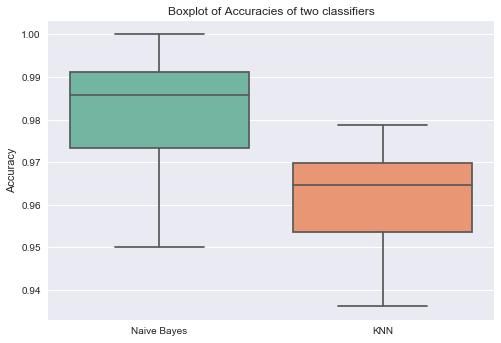

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
results = [acc_scores_nb, acc_scores_knn]
ax = sns.boxplot(data=results, palette="Set2")
ax.set_xticklabels(['Naive Bayes', 'KNN'])
plt.title("Boxplot of Accuracies of two classifiers")
plt.ylabel("Accuracy")
plt.show()

Accuracy distribution for the folds in 10 fold cross validation, Naive Bayes' accuracy is higher than KNN. The median of Naive Bayes is also higher

##### Density distribution plot of accuracy scores for k fold cross validation

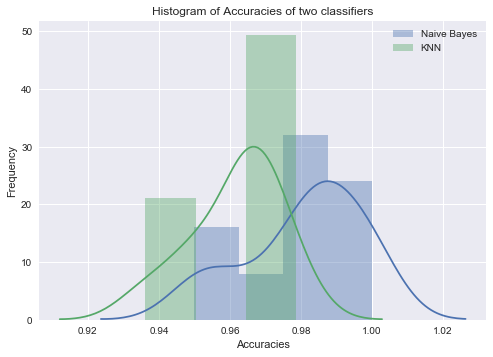

In [21]:
sns.distplot(results[0])
sns.distplot(results[1])
plt.legend(["Naive Bayes","KNN"])
plt.title("Histogram of Accuracies of two classifiers")
plt.ylabel("Frequency")
plt.xlabel("Accuracies")
plt.show()

##### Classification Scores for Naive Bayes

In [19]:
# Classification report for Naive Bayes
from sklearn.metrics import classification_report
print("********Naive Bayes Classification Report**********")
print(classification_report(y_test, predicted_nb))

********Naive Bayes Classification Report**********
             precision    recall  f1-score   support

   business       0.98      1.00      0.99       125
      sport       0.99      0.99      0.99       127
 technology       1.00      0.98      0.99       100

avg / total       0.99      0.99      0.99       352



##### Classification Scores for KNN

In [20]:
# Classification report for KNN
print("********KNN Classification Report**********")
print(classification_report(y_test, predicted_knn))

********KNN Classification Report**********
             precision    recall  f1-score   support

   business       0.98      0.97      0.97       125
      sport       0.97      0.97      0.97       127
 technology       0.96      0.97      0.97       100

avg / total       0.97      0.97      0.97       352



### Conclusion

<ul>
    <li>Accuracy measure for test set is higher for Naive Bayes than KNN</li>
    <li>Mean accuracy for 10 fold cross validation is higher in case of Naive Bayes</li>
    <li>There is not much difference in terms of Standard Deviation</li>
<ul>

##### Though performance of both the classifiers are good, from the above 3 points , accuracy scores and the plots show that Naive Bayes performed slightly better than KNN